# Toy inflationary models

## Loading the relevant libraries

In [2]:
# Pandas is a software library written for the Python programming language for data manipulation and analysis.
import pandas as pd
# NumPy is a library for the Python programming language, adding support for large, multi-dimensional arrays and matrices, along with a large collection of high-level mathematical functions to operate on these arrays
import numpy as np
from numpy.linalg import eig
# Library to generate random numbers
import random as rnd
# Library for importing additional math functions
import math
# Library for more complicated math formulas
from scipy.optimize import fmin, minimize, basinhopping

# Library for symbolic computations
import sympy as sym
from sympy import Symbol, sin, maximum, true, false, solveset, symbols, Interval, Min
from sympy.utilities.lambdify import lambdify
from sympy.plotting import plot3d

# To search in dictionaries
from itertools import chain
# To construct products of columns
from itertools import product

# Matplotlib is a plotting library for python and pyplot gives us a MatLab like plotting framework. We will use this in our plotter function to plot data.
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator # needed for integer only on axis
from matplotlib.lines import Line2D # for creating the custom legend
from matplotlib.colors import ListedColormap
from matplotlib.cm import ScalarMappable # for colorbar
# Seaborn is a Python data visualization library based on matplotlib. It provides a high-level interface for drawing attractive and informative statistical graphics
import seaborn as sns

# Preprocessing allows us to standarsize our data
from sklearn import preprocessing
# For getting metrics:
from sklearn import metrics
# Allows us to split our data into training and testing data
from sklearn.model_selection import train_test_split
# K Nearest Neighbors classification algorithm
from sklearn import neighbors, datasets
from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import DecisionBoundaryDisplay

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})

## A scan of toy models

### Basic definitions

Here we define the scalar potential, the gradient squared and the de Sitter coefficient γ for the toy model; notice that we keep the saxion powers as variables:

In [3]:
def V_toy(a,s,f,h,p,q):
    a, s, f, h, p, q = sym.symbols('a s f h p q')
    V_temp = ((f-h*a)**2)/(2*s**p) + (h**2)*(2*s**q)
    return V_temp


def metric_toy(a,s,f,h,p,q):
    a, s, f, h, p, q = sym.symbols('a s f h p q')
    metric_temp = sym.Matrix([[1/(2*(s**2)),0],[0,1/(2*(s**2))]])
    return metric_temp


def gradV_squared_toy(a,s,f,h,p,q):
    a, s, f, h, p, q = sym.symbols('a s f h p q')
    gradV_temp = sym.Matrix([sym.diff(V_toy(a,s,f,h,p,q),a),sym.diff(V_toy(a,s,f,h,p,q),s)])
    metric_inv_temp = metric_toy(a,s,f,h,p,q).inv()
    gradV_squared_temp = gradV_temp.T*metric_inv_temp*gradV_temp
    return gradV_squared_temp[0]


def gradV_can_vec_toy(a,s,f,h,p,q):
    a, s, f, h, p, q = sym.symbols('a s f h p q')
    gradV_temp = sym.Matrix([sym.diff(V_toy(a,s,f,h,p,q),a),sym.diff(V_toy(a,s,f,h,p,q),s)])
    metric_inv_temp = metric_toy(a,s,f,h,p,q).inv()
    gradV_can_vec_temp = metric_inv_temp*gradV_temp/V_toy(a,s,f,h,p,q)
    return gradV_can_vec_temp


def gamma_toy(a,s,f,h,p,q):
    a, s, f, h, p, q = sym.symbols('a s f h p q')
    gamma_temp = sym.sqrt(gradV_squared_toy(a,s,f,h,p,q))/V_toy(a,s,f,h,p,q)
    return gamma_temp


def minimum_wrt_s(f):

    # Firstly, we need to convert the Sympy function to a numpy one:
    f_l = sym.lambdify(s,f,modules=['numpy', 'sympy'])

    # Then, we build Jacobian...first with Sympy
    jac_f = [f.diff(s)]
    # then, we convert it to numpy
    jac_f_l = [sym.lambdify(s, jf, modules='numpy') for jf in jac_f]

    # We initialize the value to compute the minimum:
    zz0 = 1

    # We set up the bounds:
    bnds = ((1, 100),)

    # Finally, we minimize:
    rslts = minimize(f_l, zz0, method='SLSQP', jac=jac_f_l, bounds=bnds)

    # Create a vector with entries: (0) minimum of function; (1) vector with axion min (1,0) and saxion min (1,1)

    min_output = [rslts.fun, rslts.x] 

    return min_output


####################################################################################################

# Conversion to numpy

a, s, f, h, p, q = sym.symbols('a s f h p q')

V_toy_lam =sym.lambdify([a,s,f,h,p,q],V_toy(a,s,f,h,p,q))

gamma_toy_lam =sym.lambdify([a,s,f,h,p,q],gamma_toy(a,s,f,h,p,q))

####################################################################################################



# We define a function that takes our value of epsilon (x), and check whether it is lower than our threshold (y):
def first_slow_roll_cond(x ,y):
    if (x < y):
        first_slow_roll_t = 1
    else:
        first_slow_roll_t = 0
    return first_slow_roll_t

### Scanning different powers

We fix the values of the fluxes, and four values of $p$, $q$.

Then, we create a set (dictionary) of databases, such that:
* For each of them, we create a grid in the $(a,s)$ space;
* For each point in the grid we compute $V(a,s)$, $\gamma(a,s)$, and the local first slow-roll parameter $\varepsilon$;
* We assign the label $1$ if $\varepsilon < 1$, otherwise the label is $0$;
* We learn the regions in the $(a,s)$-space where $\varepsilon < 1$.

In [ ]:
# Number of random points
n_grid = 12

# p, q values
p_vec = [1,2,3,4]
q_vec = [1,2,3,4]

# Fixed parameters
f_fix = 1
h_fix = 1

# Field space that we scan
s_vevs = np.linspace(2, 6, n_grid)
a_vevs = np.linspace(0, 100, n_grid)

# We initialize a dictionary of dataframes:
df_toy_scan = {} 

# Define sympy variables
a, s, f, h, p, q = sym.symbols('a s f h p q')

# Creating the databases:
for i in [0,1,2]:
    for j in [0,1,2]:
        df_toy_scan[i,j] = pd.DataFrame()
        df_toy_scan[i,j]['av_values'] = [list(x) for x in product(a_vevs,s_vevs)]
        df_toy_scan[i,j]['a_values'] = df_toy_scan[i,j].apply(lambda x: x[0][0], axis = 1)
        df_toy_scan[i,j]['s_values'] = df_toy_scan[i,j].apply(lambda x: x[0][1], axis = 1)
        df_toy_scan[i,j]['V'] = df_toy_scan[i,j].apply(lambda x: V_toy_lam(x[1],x[2],f_fix,h_fix,p_vec[i],q_vec[j]), axis = 1)  
        df_toy_scan[i,j]['gamma'] = df_toy_scan[i,j].apply(lambda x: gamma_toy_lam(x[1],x[2],f_fix,h_fix,p_vec[i],q_vec[j]), axis=1)   
        df_toy_scan[i,j]['epsilon'] = df_toy_scan[i,j].apply(lambda x: pow(x[4],2)/2, axis = 1).astype(np.float64)
        df_toy_scan[i,j]['slow-roll?'] = df_toy_scan[i,j].apply(lambda x: first_slow_roll_cond(x[5],0.5), axis = 1)


# Check output
df_toy_scan[0,2].head()

,av_values,a_values,s_values,V,gamma,epsilon,slow-roll?
0,"[0.0, 2.0]",0.0,2.000000,16.250000,4.156523,8.638343,0
1,"[0.0, 2.3636363636363638]",0.0,2.363636,26.621756,4.198027,8.811715,0
2,"[0.0, 2.7272727272727275]",0.0,2.727273,40.754333,4.217336,8.892962,0
3,"[0.0, 3.090909090909091]",0.0,3.090909,59.221119,4.227256,8.934848,0
4,"[0.0, 3.4545454545454546]",0.0,3.454545,82.597028,4.232763,8.958140,0


Here we plot the points in the $(a,s)$-space, with the assigned labels:

/var/folders/yf/1vf5nhvs2n9byl844qlkc6880000gn/T/ipykernel_2806/1542511560.py:54: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


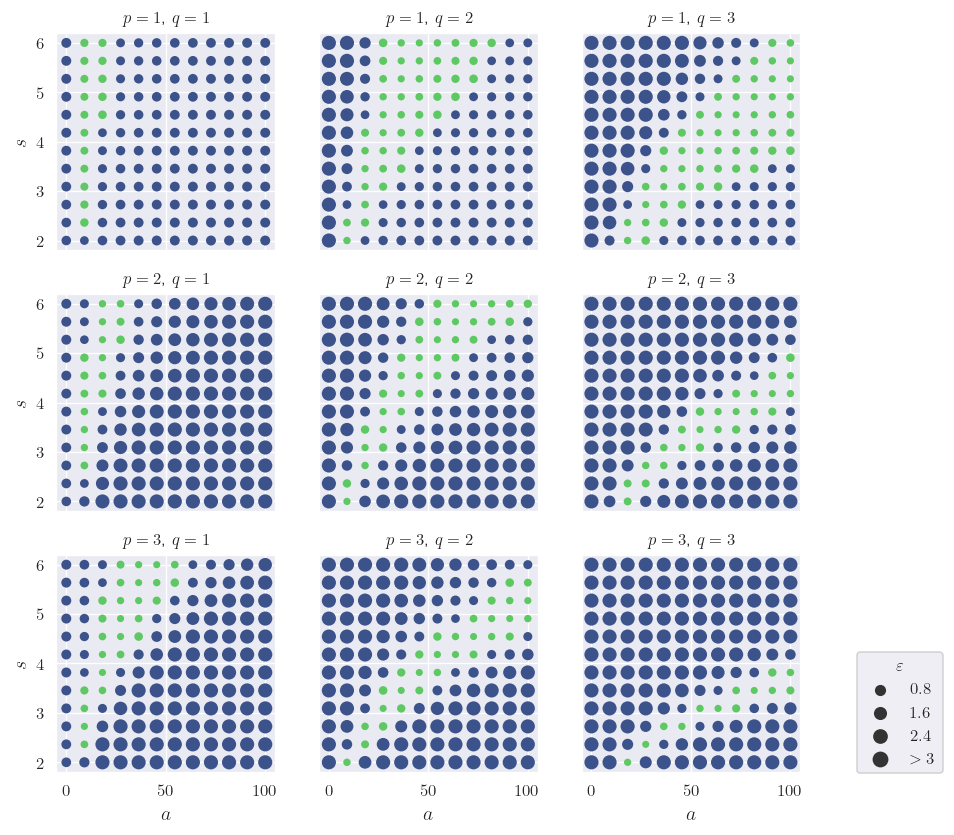

In [5]:
sns.set_style("darkgrid")

# set norm for hue and size - to change eventually
norm_plot = (0,3)
hue_order = df_toy_scan[0,2]['slow-roll?'].unique()

# Create color maps
colors = [sns.color_palette("viridis", n_colors=3)[0],   
            sns.color_palette("viridis", n_colors=3)[2]]
cmap_bold = colors
cmap_light = ListedColormap([sns.color_palette("viridis", n_colors=3)[0],   
            sns.color_palette("viridis", n_colors=3)[2]])

fig, axes = plt.subplots(3, 3, sharex = True, sharey = True, figsize=(8,8), dpi=120)

# plt.suptitle("Parameter space for which $\\varepsilon < \\frac{1}{2}$")

plt.subplots_adjust(hspace=0.2,wspace=0.2)

Xtrain ={}
Xtrain_norm = {}
ytrain ={}
scaler = {}

for i in [0,1,2]:
    for j in [0,1,2]:

        sns.scatterplot(data = df_toy_scan[i,j], ax = axes[i,j], x= df_toy_scan[i,j]['a_values'], y = df_toy_scan[i,j]['s_values'], 
                        marker='o', 
                        size = df_toy_scan[i,j]['epsilon'], size_norm = norm_plot,
                        hue_order = hue_order, hue = df_toy_scan[i,j]['slow-roll?'], 
                        palette = cmap_bold, linewidth=0, legend = True)
        
        

        axes[i,j].set_xlabel('$a$', fontsize='large')
        axes[i,j].set_ylabel('$s$', fontsize='large')
        axes[i,j].set_title('$p = {}$, $q = {}$'.format(p_vec[i],q_vec[j]),fontsize=10)
        
# get current legend's handles and labels
handles, labels =  axes[0,1].get_legend_handles_labels()
for i in [0,1,2]:
    for j in [0,1]:
        axes[i,j].get_legend().remove()

axes[1,2].get_legend().remove()
axes[2,2].get_legend().remove()


labels[7] = '$\\mathdefault{>3}$'
axes[0,2].legend(handles[4:],labels[4:], loc='lower left', title='$\\varepsilon$', bbox_to_anchor=(0.95,0.1), ncol=1, bbox_transform=fig.transFigure)


plt.tight_layout()
plt.show()

...and we learn the regions via the $k$-nearest neighbor algorithm:

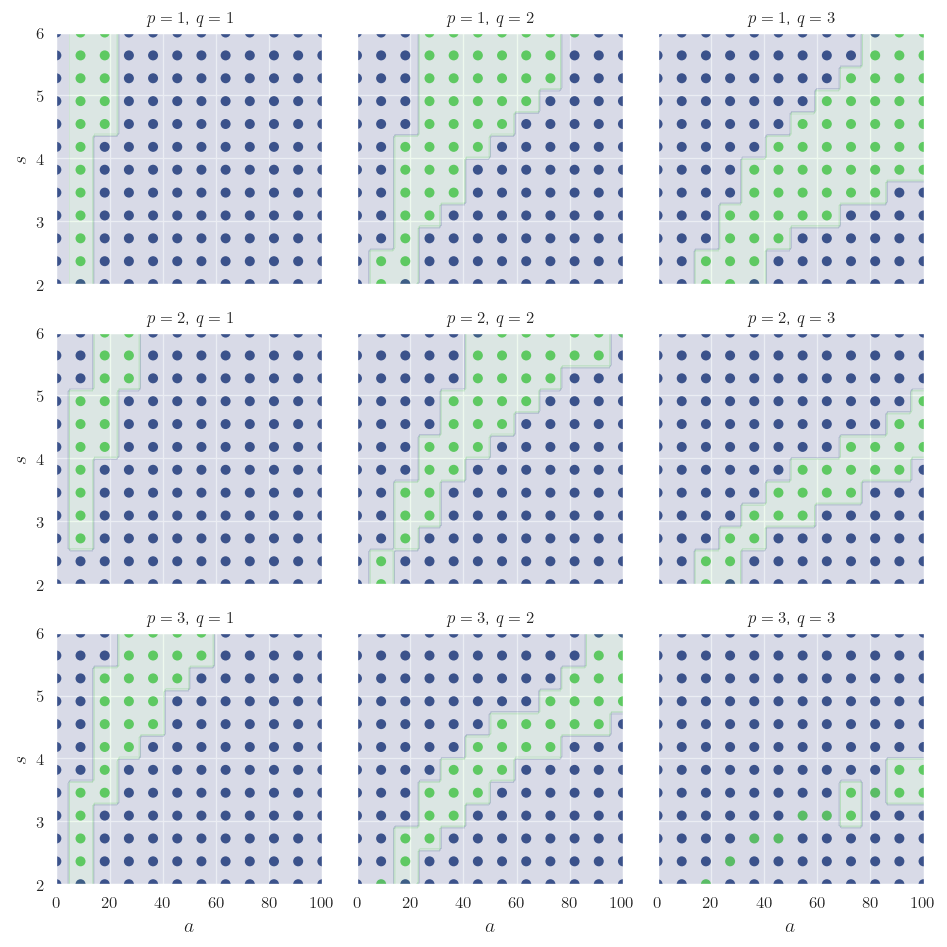

In [ ]:
sns.set_style("darkgrid")

# set norm for hue and size - to change eventually
norm_plot = (0,3)
hue_order = df_toy_scan[0,2]['slow-roll?'].unique()

# Create color maps
colors = [sns.color_palette("viridis", n_colors=3)[0],   
            sns.color_palette("viridis", n_colors=3)[2]]
cmap_bold = colors
cmap_light = ListedColormap([sns.color_palette("viridis", n_colors=3)[0],   
            sns.color_palette("viridis", n_colors=3)[2]])

fig, axes = plt.subplots(3, 3, sharex = True, sharey = True, figsize=(8,8), dpi=120)

plt.subplots_adjust(hspace=0.2,wspace=0.2)

Xtrain ={}
Xtrain_norm = {}
ytrain ={}
scaler = {}

for i in [0,1,2]:
    for j in [0,1,2]:
        # Apply kNN
        Xtrain[i,j] = df_toy_scan[i,j][['a_values','s_values']]
        ytrain[i,j]= df_toy_scan[i,j][['slow-roll?']]
        
        model = KNeighborsClassifier(n_neighbors = 3, weights='uniform').fit(Xtrain[i,j],ytrain[i,j].values.ravel())        
        model.fit(Xtrain[i,j], ytrain[i,j].values.ravel())

        sns.scatterplot(data = df_toy_scan[i,j], ax = axes[i,j], x= df_toy_scan[i,j]['a_values'], y = df_toy_scan[i,j]['s_values'], 
                        marker='o', 
                        hue_order = hue_order, hue = df_toy_scan[i,j]['slow-roll?'], 
                        palette = cmap_bold, linewidth=0, legend = False)
        

        DecisionBoundaryDisplay.from_estimator(
            model,
            Xtrain[i,j],
            grid_resolution = 100,
            cmap = cmap_light,
            ax=axes[i,j],
            response_method="predict",
            plot_method="contourf",
            #shading="auto",
            alpha = 0.1,
            )
        

        axes[i,j].set_xlabel('$a$', fontsize='large')
        axes[i,j].set_ylabel('$s$', fontsize='large')
        axes[i,j].set_title('$p = {}$, $q = {}$'.format(p_vec[i],q_vec[j]),fontsize=10)
        
plt.xlim(0, 100)
plt.ylim(2, 6)

plt.tight_layout()
plt.show()

### Scanning different powers - the backreaction

We fix the values of the fluxes, and four values of $p$, $q$.

Then, we create a set (dictionary) of databases, such that:
* We create a grid of axion points;
* At each point of the grid, we compute the saxion vev $s_{min}$ that minimizes the scalar potential;
* At each point $(a,s_{min})$ we compute the de Sitter coefficient;
* We plot the data so obtained.

In [ ]:
# Number of random points
n_grid = 25

# Axion/saxion vevs

p_vec = [1,2,3,4,5]
q_vec = [1,2,3,4,5]

# Fixed parameters
f_fix = 1
h_fix = 1

# Parameters that we scan
a_vevs = np.linspace(20, 200, n_grid)

# We initialize a dictionary of dataframes:
df_toy_valley_scan = {} 

# Define sympy variables
a, s, f, h, p, q = sym.symbols('a s f h p q')


# Creating the databases:
for i in [0,1,2]:
    for j in [0,1,2]:
        df_toy_valley_scan[i,j] = pd.DataFrame()
        df_toy_valley_scan[i,j]['a_vevs'] = a_vevs
        df_toy_valley_scan[i,j]['V_axion'] = df_toy_valley_scan[i,j].apply(lambda x: V_toy_lam(x[0],s,f_fix,h_fix,p_vec[i],q_vec[j]), axis = 1)
        df_toy_valley_scan[i,j]['min_saxion'] = df_toy_valley_scan[i,j].apply(lambda x: minimum_wrt_s(x[1])[1][0], axis = 1)
        df_toy_valley_scan[i,j]['gamma_min'] = df_toy_valley_scan[i,j].apply(lambda x: gamma_toy_lam(x[0],x[2],f_fix,h_fix,p_vec[i],q_vec[j]), axis = 1)


# Check output
df_toy_valley_scan[0,0].head()

,a_vevs,V_axion,min_saxion,gamma_min
0,20.0,2*s + 180.5/s,9.499602,0.707107
1,27.5,2*s + 351.125/s,13.249917,0.707107
2,35.0,2*s + 578.0/s,16.999879,0.707107
3,42.5,2*s + 861.125/s,20.749960,0.707107
4,50.0,2*s + 1200.5/s,24.498738,0.707107


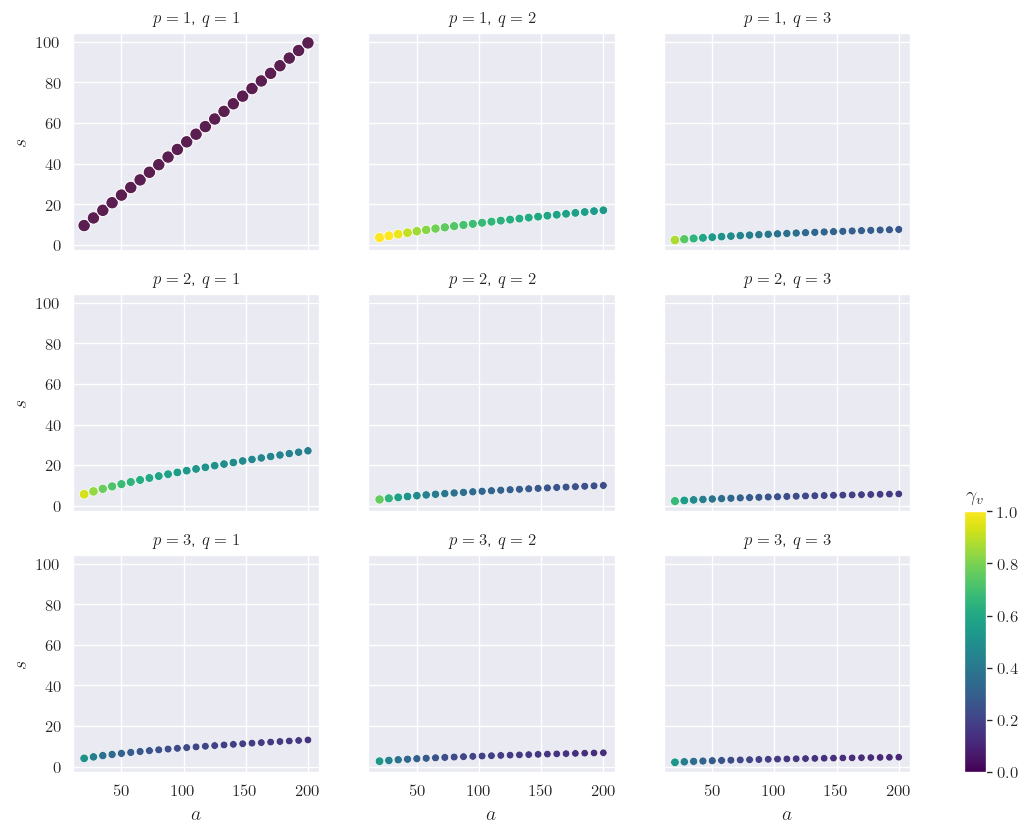

In [ ]:
sns.set_style("darkgrid")

# Create color maps
colors = [sns.color_palette("viridis", n_colors=3)[1],   
            sns.color_palette("viridis", n_colors=3)[0],
            sns.color_palette("viridis", n_colors=3)[2]]
cmap_bold = colors
cmap_light = ListedColormap(colors)
norm_sm = plt.Normalize(0,1)
norm_h = plt.Normalize(0,0.3)

fig, axes = plt.subplots(3, 3, sharex = True, sharey = True, figsize=(9,8), dpi=120)

# plt.suptitle("The de Sitter coefficient through saxion valleys")

plt.subplots_adjust(hspace=0.2,wspace=0.2)

for i in [0,1,2]:
    for j in [0,1,2]:
        if i==0 and j==0:
            sns.scatterplot(data = df_toy_valley_scan[i,j], 
                            ax = axes[i,j], 
                            x= df_toy_valley_scan[i,j]['a_vevs'], 
                            y = df_toy_valley_scan[i,j]['min_saxion'], 
                            marker='o', 
                            size = df_toy_valley_scan[i,j]['gamma_min'], 
                            size_norm = norm_sm,
                            hue = df_toy_valley_scan[i,j]['gamma_min'], 
                            hue_norm = plt.Normalize(0,3),
                            palette = "rocket", legend = False)
            axes[i,j].set_xlabel('$a$', fontsize='large')
            axes[i,j].set_ylabel('$s$', fontsize='large')
            axes[i,j].set_title('$p = {}$, $q = {}$'.format(p_vec[i],q_vec[j]),fontsize=10)
        else: 
            sns.scatterplot(data = df_toy_valley_scan[i,j], 
                            ax = axes[i,j], 
                            x= df_toy_valley_scan[i,j]['a_vevs'], 
                            y = df_toy_valley_scan[i,j]['min_saxion'], 
                            marker='o', 
                            size = df_toy_valley_scan[i,j]['gamma_min'], 
                            size_norm = norm_sm,
                            hue = df_toy_valley_scan[i,j]['gamma_min'], 
                            hue_norm = norm_h,
                            palette = "viridis", legend = False)
            axes[i,j].set_xlabel('$a$', fontsize='large')
            axes[i,j].set_ylabel('$s$', fontsize='large')
            axes[i,j].set_title('$p = {}$, $q = {}$'.format(p_vec[i],q_vec[j]),fontsize=10)




# colorbar

norm_color = norm_sm
cmap = sns.color_palette("viridis", as_cmap=True)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm_sm)
sm.set_array([])

cax = fig.add_axes([axes[2,2].get_position().x1+0.05, axes[2,2].get_position().y0, 0.02, axes[2,2].get_position().height *1.2])
cax.set_title('$\gamma_v$')
axes[0,2].figure.colorbar(sm, cax=cax)

plt.show()

### Scanning different fluxes

We fix the values of the $p$, $q$, and three values of fluxes.

Then, we create a set (dictionary) of databases, such that:
* For each of them, we create a grid in the $(a,s)$ space;
* For each point in the grid we compute $V(a,s)$, $\gamma(a,s)$, and the local first slow-roll parameter $\varepsilon$;
* We assign the label $1$ if $\varepsilon < 1$, otherwise the label is $0$;
* We learn the regions in the $(a,s)$-space where $\varepsilon < 1$.

In [ ]:
# Number of random points
n_grid = 12

# Axion/saxion vevs

f_vec = [1,5,50]
h_vec = [1,5,50]

# Fixed parameters
p_fix = 1
q_fix = 2

# Parameters that we scan
s_vevs = np.linspace(2, 10, n_grid)
a_vevs = np.linspace(0, 100, n_grid)

# We initialize a dictionary of dataframes:
df_toy_scan_b = {} 

# Define sympy variables
a, s, f, h, p, q = sym.symbols('a s f h p q')


# Creating the databases:
for i in [0,1,2]:
    for j in [0,1,2]:
        df_toy_scan_b[i,j] = pd.DataFrame()
        df_toy_scan_b[i,j]['av_values'] = [list(x) for x in product(a_vevs,s_vevs)]
        df_toy_scan_b[i,j]['a_values'] = df_toy_scan_b[i,j].apply(lambda x: x[0][0], axis = 1)
        df_toy_scan_b[i,j]['s_values'] = df_toy_scan_b[i,j].apply(lambda x: x[0][1], axis = 1)
        df_toy_scan_b[i,j]['V'] = df_toy_scan_b[i,j].apply(lambda x: V_toy_lam(x[1],x[2],f_vec[i],h_vec[j],p_fix,q_fix), axis = 1)  
        df_toy_scan_b[i,j]['gamma'] = df_toy_scan_b[i,j].apply(lambda x: gamma_toy_lam(x[1],x[2],f_vec[i],h_vec[j],p_fix,q_fix), axis=1)   
        df_toy_scan_b[i,j]['epsilon'] = df_toy_scan_b[i,j].apply(lambda x: pow(x[4],2)/2, axis = 1).astype(np.float64)
        df_toy_scan_b[i,j]['slow-roll?'] = df_toy_scan_b[i,j].apply(lambda x: first_slow_roll_cond(x[5],0.5), axis = 1)


# Check output
df_toy_scan_b[0,2].head()

,av_values,a_values,s_values,V,gamma,epsilon,slow-roll?
0,"[0.0, 2.0]",0.0,2.000000,20000.250000,2.828376,3.999856,0
1,"[0.0, 2.7272727272727275]",0.0,2.727273,37190.265978,2.828407,3.999943,0
2,"[0.0, 3.4545454545454546]",0.0,3.454545,59669.566224,2.828417,3.999972,0
3,"[0.0, 4.181818181818182]",0.0,4.181818,87438.136094,2.828421,3.999984,0
4,"[0.0, 4.909090909090909]",0.0,4.909091,120495.969620,2.828424,3.999990,0


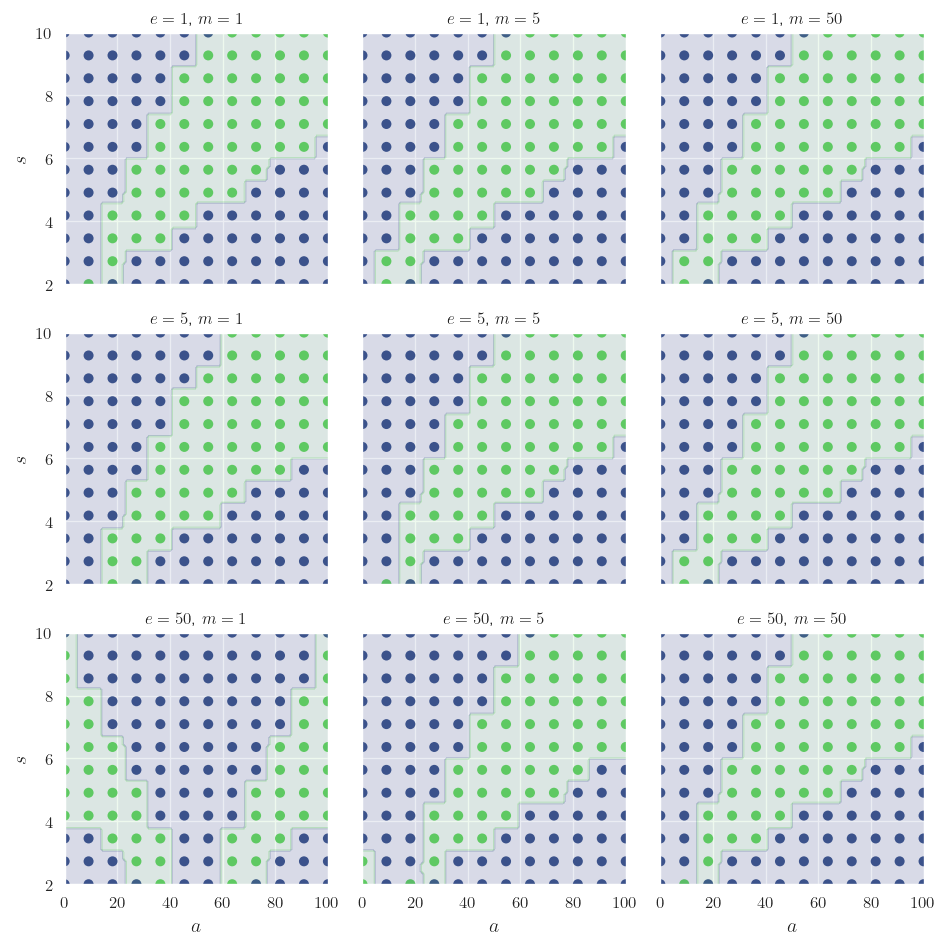

In [ ]:
sns.set_style("darkgrid")

# set norm for hue and size - to change eventually
norm_plot = (0,3)
hue_order = df_toy_scan_b[0,2]['slow-roll?'].unique()

# Create color maps
colors = [sns.color_palette("viridis", n_colors=3)[0],   
            sns.color_palette("viridis", n_colors=3)[2]]
cmap_bold = colors
cmap_light = ListedColormap([sns.color_palette("viridis", n_colors=3)[0],   
            sns.color_palette("viridis", n_colors=3)[2]])

fig, axes = plt.subplots(3, 3, sharex = True, sharey = True, figsize=(8,8), dpi=120)


plt.subplots_adjust(hspace=0.2,wspace=0.2)

Xtrain_b ={}
ytrain_b ={}

for i in [0,1,2]:
    for j in [0,1,2]:
        # Apply kNN
        Xtrain_b[i,j] = df_toy_scan_b[i,j][['a_values','s_values']]
        ytrain_b[i,j]= df_toy_scan_b[i,j][['slow-roll?']]
        
        model_b = KNeighborsClassifier(n_neighbors = 3, weights='uniform').fit(Xtrain_b[i,j],ytrain_b[i,j].values.ravel())
        model_b.fit(Xtrain_b[i,j], ytrain_b[i,j].values.ravel())

        sns.scatterplot(data = df_toy_scan_b[i,j], ax = axes[i,j], x= df_toy_scan_b[i,j]['a_values'], y = df_toy_scan_b[i,j]['s_values'], 
                        marker='o', 
                        hue_order = hue_order, hue = df_toy_scan_b[i,j]['slow-roll?'], 
                        palette = cmap_bold, linewidth=0, legend = False)
        

        DecisionBoundaryDisplay.from_estimator(
            model_b,
            Xtrain_b[i,j],
            grid_resolution = 100,
            cmap = cmap_light,
            ax=axes[i,j],
            response_method="predict",
            plot_method="contourf",
            #shading="auto",
            alpha = 0.1,
            )
        

        axes[i,j].set_xlabel('$a$', fontsize='large')
        axes[i,j].set_ylabel('$s$', fontsize='large')
        axes[i,j].set_title('$e = {}$, $m = {}$'.format(f_vec[i],h_vec[j]),fontsize=10)
        
plt.xlim(0, 100)
plt.ylim(2, 10)

plt.tight_layout()
plt.show()